# Diamond sensor data collection and analysis

xchong@lbl.gov, awojdyla@lbl.gov, May 2024

# Step 1: Move the m101 pitch slightly and see what happens

In [1]:
import epics
import bluesky
import numpy as np

In [2]:
from bluesky import RunEngine
RE = RunEngine({})

from databroker import Broker
db = Broker.named('temp')

# Insert all metadata/data captured into db.
RE.subscribe(db.insert)

0

In [3]:
from ophyd import EpicsMotor
import ophyd
#ophyd.set_cl('caproto')

#for diode_mA, use EpicsSignal() instead of EpicsMotor
diode_mA = ophyd.EpicsSignal('bl201-beamstop:current', name='photodiode') 
diode_mA.wait_for_connection(timeout=2.0)
diode_mA.read()

{'photodiode': {'value': -0.4903, 'timestamp': 1719615721.053714}}

In [4]:
#For the 1st experiment on 20231215, we use mono_angle_deg only (which does not work, no edge found)
#pv_mono_angle_deg = 'bl531_xps1:mono_angle_deg'
#pv_photodiode_mA  = 'bl201-beamstop:current'


pv_m101_pitch_mm  = 'bl531_esp300:m101_pitch_mm'
# #pv_m101_bend_um   = 'bl531_esp300:m101_bend_um'
# pv_mono_height_mm = 'bl531_xps1:mono_height_mm'

In [5]:
m101_pitch_mm = EpicsMotor(pv_m101_pitch_mm, name='m101_pitch_mm')
m101_pitch_mm.wait_for_connection(timeout=2.0)
m101_pitch_mm.read()

OrderedDict([('m101_pitch_mm',
              {'value': 0.7983699999999999, 'timestamp': 1719515701.875241}),
             ('m101_pitch_mm_user_setpoint',
              {'value': 0.7983512282371521, 'timestamp': 1719515701.875241})])

In [6]:
#Run this line before starting angle scan, otherwise the edge does not look good
m101_pitch_mm.read()

OrderedDict([('m101_pitch_mm',
              {'value': 0.7983699999999999, 'timestamp': 1719515701.875241}),
             ('m101_pitch_mm_user_setpoint',
              {'value': 0.7983512282371521, 'timestamp': 1719515701.875241})])

In [7]:

#physical constants
h_m2kgps = 6.6261e-34
c_mps    = 299792458   
e_eV     = 6.2415e+18
# Silicon spacing (for Bragg condition)
Si_m = 5.43E-10
a_Si111_m = Si_m/np.sqrt(1^2+1^2+1^2)
# Monochromotor offset
mono_offset_deg = 12.787
#Wavelength from energy
lambda_m = lambda E_eV : h_m2kgps*c_mps*e_eV/E_eV
#Bragg angle from Wavelength
bragg_deg = lambda E_eV: np.arcsin(lambda_m(E_eV)/(2*a_Si111_m))*180/np.pi
# Mono angle from Bragg angle
mono_deg = lambda E_eV: bragg_deg(E_eV)+mono_offset_deg

# inverse function to go from mono angle to eV
energy_eV = lambda mono_deg_input: (h_m2kgps*c_mps*e_eV)/((2 * a_Si111_m) * np.sin((np.pi/180)*(mono_deg_input - mono_offset_deg)))

In [103]:
#m101_pitch_mm.move(0.819982)
#6-9kev
energy=9000
mono_deg(energy)

epics.caput('bl531_xps1:mono_angle_deg',mono_deg(energy))
epics.caget('bl531_xps1:mono_angle_deg')

25.479182679068188

# Step 2 Get the diamond sensor image

# parse the ice-cream data

In [104]:
def find_all(sub,s):
    index_list=[]
    index = s.find(sub)
    while index!=-1:
        index_list.append(index)
        index = s.find(sub,index+1)
    if len(index_list)>0:
        return index_list
    else:
        return -1

In [105]:
import subprocess
import numpy as np

# cmd = "pvget ice-cream/image"
# process = subprocess.Popen(cmd.split(),
#                      stdout=subprocess.PIPE)
# processed, _ = process.communicate()
# ice_cream= processed.decode("utf-8")
# x = ice_cream.split('\n')
# for i in range (len(x)):
#     print(i,x[i])
# start = find_all("[",x[2])[-1]
# end = find_all("]",x[2])[-1]
# value = x[2][start+1:end].split(',')
# res = [eval(i) for i in value]
# res = np.resize(np.array(res),(50,48))
# process.kill()
# process.terminate()

In [115]:
import subprocess
output = subprocess.getoutput('pvget ice-cream/image')
x = output.split('\n')
for i in range (len(x)):
    print(i,x[i])
start = find_all("[",x[2])[-1]
end = find_all("]",x[2])[-1]
value = x[2][start+1:end].split(',')
res = [eval(i) for i in value]
res = np.resize(np.array(res),(48,50))

0 ice-cream/image structure 
1     any value
2         int[]  [42,-15,46,-1,83,-38,62,-34,51,-58,40,-21,25,-25,50,-36,65,-22,33,-28,19,-44,37,-18,26,-41,45,-27,63,-27,36,-49,51,-10,48,-6,85,17,70,-5,56,-5,53,-1,44,-8,49,-37,21,14,14,-47,8,28,17,16,-10,-90,61,47,31,9,53,4,79,38,-22,14,31,55,33,-7,34,10,66,26,0,11,31,54,50,-39,56,50,70,-19,34,40,14,23,-1,12,-6,31,3,-49,37,-57,49,16,42,-13,31,-19,62,-26,19,-51,29,-36,31,-30,24,-43,20,-29,52,-33,20,-11,45,-43,43,-26,17,-38,26,-15,39,-2,12,-53,67,-16,20,-11,49,2,96,14,51,3,41,6,61,0,49,-37,30,-9,36,-9,-2,32,-8,1,23,-60,29,74,21,11,59,15,64,23,-40,23,26,52,25,-15,-3,3,23,32,-17,32,22,47,41,-35,34,46,64,15,8,51,2,32,-13,47,-9,25,-1,-14,22,-38,13,10,26,22,11,-1,25,-5,22,-13,23,-9,1,-18,7,-17,29,-32,47,2,0,-7,5,-23,22,12,11,-17,0,-15,14,-1,20,-18,20,1,-19,-26,40,-27,20,15,42,8,45,20,37,35,57,0,13,9,47,-13,25,43,21,14,0,-55,55,44,30,17,32,-2,56,21,-37,23,11,55,20,-25,27,18,45,17,15,27,25,61,37,-44,37,21,62,1,46,55,18,23,11,30,3,44,-4,-42,44,-48,

In [116]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
# subprocess = os.popen('pvget ice-cream/image')
# ice_cream = subprocess.read()
# x = ice_cream.split('\n')
# for i in range (len(x)):
#     print(i,x[i])
# start = find_all("[",x[2])[-1]
# end = find_all("]",x[2])[-1]
# value = x[2][start+1:end].split(',')
# res = [eval(i) for i in value]
# res = np.resize(np.array(res),(50,48))
# subprocess.close()


## calculate size and center for the collected gaussian source

In [117]:
def centroid1(x_px,I):
    xc_px = np.sum(I*x_px)/np.sum(I)
    return xc_px

def size_rms1(x_px,I):
    xc_px = centroid1(x_px,I)
    stdev = np.sqrt(np.sum(I*(x_px-xc_px)**2)/np.sum(I))
    return stdev

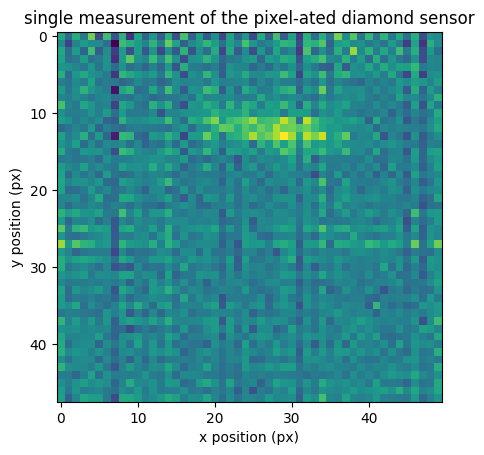

In [118]:
Nx = 50
x_px = np.arange(Nx)
Ny = 48
y_px = np.arange(Ny)


source_gaussian = res
plt.xlabel("x position (px)")
plt.ylabel("y position (px)")
plt.title("single measurement of the pixel-ated diamond sensor")
plt.imshow(source_gaussian)
plt.show()

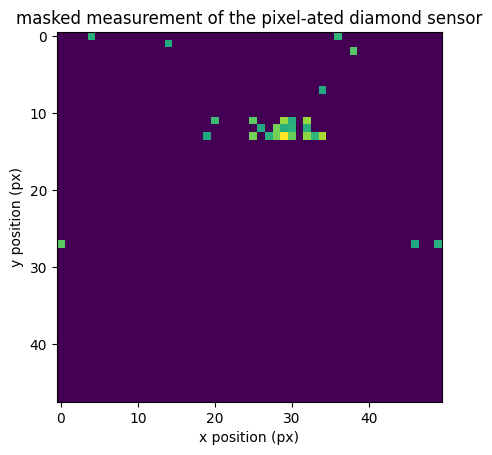

In [119]:
source_gaussian_masked = np.where(source_gaussian>(0.6*np.max(source_gaussian)),source_gaussian,0)
plt.imshow(source_gaussian_masked)
plt.xlabel("x position (px)")
plt.ylabel("y position (px)")
plt.title("masked measurement of the pixel-ated diamond sensor")
plt.show()

In [120]:
center_x_px = centroid1(x_px, np.sum(source_gaussian_masked,0))
size_x_px = size_rms1(x_px, np.sum(source_gaussian_masked,0))
print("x-axis center and size:",center_x_px,size_x_px*2.35)

center_y_px = centroid1(y_px, np.sum(source_gaussian_masked,1))
size_y_px = size_rms1(y_px, np.sum(source_gaussian_masked,1))
print("y-axis center and size:",center_y_px,size_y_px*2.35)

x-axis center and size: 28.135091926458834 23.285735768955288
y-axis center and size: 12.0171862509992 15.208730326593956


In [121]:
dx_m=50*1e-6

y_m = np.arange(48)*dx_m
x_m = np.arange(50)*dx_m

center_x_m = centroid1(x_m, np.sum(source_gaussian_masked,0))
size_x_m = size_rms1(x_m, np.sum(source_gaussian_masked,0))
print("x-axis center and rms size:",center_x_m*1e6,size_x_m*1e6)

center_y_m = centroid1(y_m, np.sum(source_gaussian_masked,1))
size_y_m = size_rms1(y_m, np.sum(source_gaussian_masked,1))
print("y-axis center and rms size:",center_y_m*1e6,size_y_m*1e6)

x-axis center and rms size: 1406.7545963229413 495.44118657351675
y-axis center and rms size: 600.85931254996 323.5900069488075


# Step 3 collect 100 images and save locally

In [122]:
from PIL import Image
from tqdm import tqdm
import time


number_of_data = 100
data = np.zeros((number_of_data*1,48,50))

In [123]:
# for i in tqdm(range(number_of_data)):
#     subprocess = os.popen('pvget ice-cream/image')
#     ice_cream = subprocess.read()
#     x = ice_cream.split('\n')
    
#     start = find_all("[",x[2])[-1]
#     end = find_all("]",x[2])[-1]
#     value = x[2][start+1:end].split(',')
#     res = [eval(i) for i in value]
#     res = np.resize(np.array(res),(50,48))
#     data[i]=res
#     subprocess.close()
    
#     time.sleep(1)

# for i in tqdm(range(number_of_data)):
#     cmd = "pvget ice-cream/image"
#     process = subprocess.Popen(cmd.split(),
#                         stdout=subprocess.PIPE)
#     processed, _ = process.communicate()
#     ice_cream= processed.decode("utf-8")
#     x = ice_cream.split('\n')

#     start = find_all("[",x[2])[-1]
#     end = find_all("]",x[2])[-1]
#     value = x[2][start+1:end].split(',')
#     res = [eval(i) for i in value]
#     res = np.resize(np.array(res),(50,48))
#     data[i]=res
#     process.kill()
#     process.terminate()
#     time.sleep(1)

folder_index=1

save_path = '/home/bl531/Documents/diamond_images_0628_diamond/'+str(energy)+'/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

for i in tqdm(range(number_of_data)):
    output = subprocess.getoutput('pvget ice-cream/image')
    x = output.split('\n')
    start = find_all("[",x[2])[-1]
    end = find_all("]",x[2])[-1]
    value = x[2][start+1:end].split(',')
    res = [eval(i) for i in value]
    res = np.resize(np.array(res),(48,50))
    #print(res)

    save_image_path = save_path + 'images_tiff_'+str(folder_index)+'/'
    if not os.path.exists(save_image_path):
        os.makedirs(save_image_path)

    im = Image.fromarray(res.astype(np.float32))
    im.save(save_image_path+str(i)+'.tiff',"tiff")

    #data[folder_index*100+i]=res



100%|██████████| 100/100 [00:21<00:00,  4.67it/s]


Text(0.5, 1.0, 'single measurement of the pixel-ated diamond sensor')

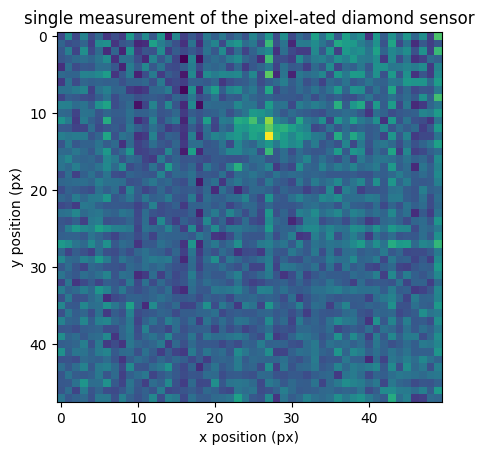

In [124]:
test_index =99
im_png = Image.open(save_path + 'images_tiff_1/'+str(test_index)+'.tiff')
im_png_arr = np.array(im_png)
plt.imshow(im_png_arr)
plt.xlabel("x position (px)")
plt.ylabel("y position (px)")
plt.title("single measurement of the pixel-ated diamond sensor")

In [ ]:


#for i_a in tqdm(np.arange(len(mono_angles_deg))):

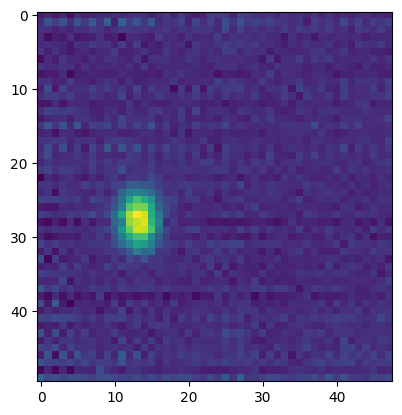

In [35]:
# import csv

# filepath = '/home/bl531/Downloads/run_19700101T054256Z.csv'
# a = csv.reader(filepath)
# i=0
# with open(filepath,mode='r') as file:
#     csvFile =csv.reader(file)
#     for lines in csvFile:
#         i+=1
#         if i==2:
#             #value = lines.split(',')
#             res = [eval(i) for i in lines]
#             res = np.resize(np.array(res),(50,48))
#             plt.imshow(res)



# Step 4: get the avg of 100 images and cal center/size

(100, 48, 50)


Text(0.5, 1.0, 'single measurement of the pixel-ated diamond sensor')

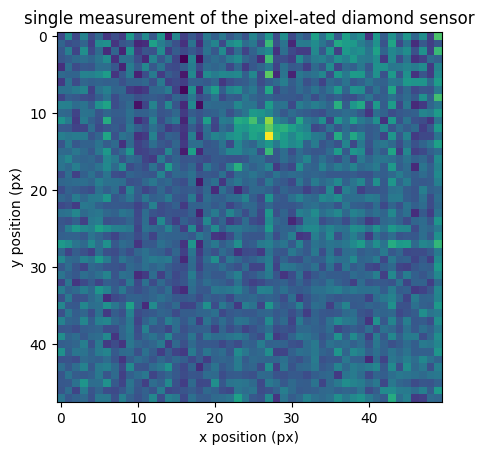

In [125]:

save_path = '/home/bl531/Documents/diamond_images_0628_diamond/'+str(energy)+'/'
data = np.zeros((100,48,50))
for folder in range (1):
    for i in range (100):
        filename = save_path + 'images_tiff_'+str(folder+1)+'/'+str(i)+'.tiff'
        #print(filename)
        im_png = Image.open(filename)
        im_png_arr = np.array(im_png)
        data[folder*100+i]=im_png_arr
print(data.shape)
plt.imshow(data[-1])
plt.xlabel("x position (px)")
plt.ylabel("y position (px)")
plt.title("single measurement of the pixel-ated diamond sensor")

Text(0.5, 1.0, 'masked measurement of the pixel-ated diamond sensor')

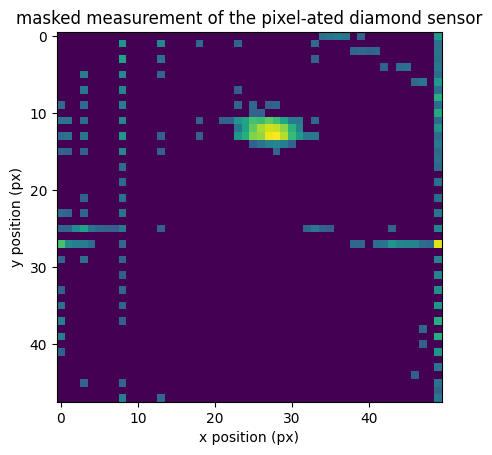

In [126]:
data_avg = np.mean(data,0)
data_avg_masked = np.where(data_avg>(0.3*np.max(data_avg)),data_avg,0)
plt.imshow(data_avg_masked)
plt.xlabel("x position (px)")
plt.ylabel("y position (px)")
plt.title("masked measurement of the pixel-ated diamond sensor")

In [127]:
avg_center_x_px = centroid1(x_px, np.sum(data_avg_masked,0))
avg_size_x_px = size_rms1(x_px, np.sum(data_avg_masked,0))
print("x-axis center and rms size:",avg_center_x_px,avg_size_x_px)
avg_center_y_px = centroid1(y_px, np.sum(data_avg_masked,1))
avg_size_y_px = size_rms1(y_px, np.sum(data_avg_masked,1))
print("y-axis center and rms size:",avg_center_y_px,avg_size_y_px)

x-axis center and rms size: 26.237116228841092 16.95902413884414
y-axis center and rms size: 17.149038339853142 11.493730004170736


## create a fake gaussian with same center and size

Text(0.5, 1.0, 'fake gaussian simulation')

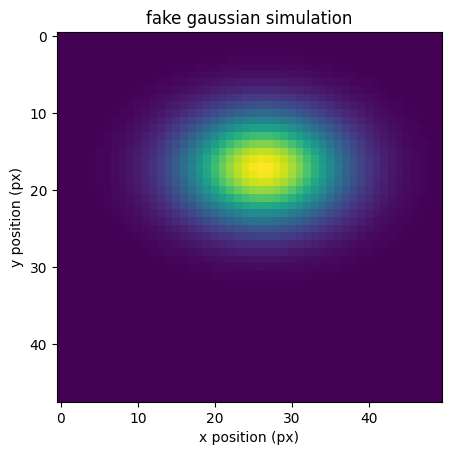

In [128]:
#define the gaussian function
def gaussian(x_px, mean_px, fwhm_px):
    '''
    GAUSSIAN Returns a 1D gaussian
    gaussian(x_px, mean_px, fwhm_px)
    :param x_px: numpy array
    :param mean_px: double
    :param fwhm_px: double
    :return: numpy array
    '''
    sigma_x = fwhm_px/(2*np.sqrt(2*np.log(2)))
    return np.exp(-((x_px-mean_px)/(np.sqrt(2)*sigma_x))**2)
X,Y = np.meshgrid(x_px,y_px)
fake_gaussian = gaussian(X, avg_center_x_px, avg_size_x_px)*gaussian(Y, avg_center_y_px, avg_size_y_px)
plt.imshow(fake_gaussian)
plt.xlabel("x position (px)")
plt.ylabel("y position (px)")
plt.title("fake gaussian simulation")

In [129]:
# center_x_list=[]
# size_x_list=[]
# center_y_list=[]
# size_y_list=[]
# for k in range(data.shape[0]):
#     each_data = data[k]

#     each_center_x_px = centroid1(x_px, np.sum(each_data,0))
#     each_size_x_px = size_rms1(x_px, np.sum(each_data,0))*2.35
#     each_center_y_px = centroid1(y_px, np.sum(each_data,1))
#     each_size_y_px = size_rms1(y_px, np.sum(each_data,1))*2.35

#     center_x_list.append(each_center_x_px)
#     size_x_list.append(each_size_x_px)
#     center_y_list.append(each_center_y_px)
#     size_y_list.append(each_size_y_px)

center_x_list=[]
size_x_list=[]
center_y_list=[]
size_y_list=[]
for k in range(data.shape[0]):
    each_data = data[k]

    each_center_x_m = centroid1(x_m, np.sum(each_data,0))
    each_size_x_m = size_rms1(x_m, np.sum(each_data,0))*2.35
    each_center_y_m = centroid1(y_m, np.sum(each_data,1))
    each_size_y_m= size_rms1(y_m, np.sum(each_data,1))*2.35

    center_x_list.append(each_center_x_m*1e6)
    size_x_list.append(each_size_x_m)
    center_y_list.append(each_center_y_m)
    size_y_list.append(each_size_y_m)

centroid error std: 89.74143515518554 um


Text(0, 0.5, 'frequency')

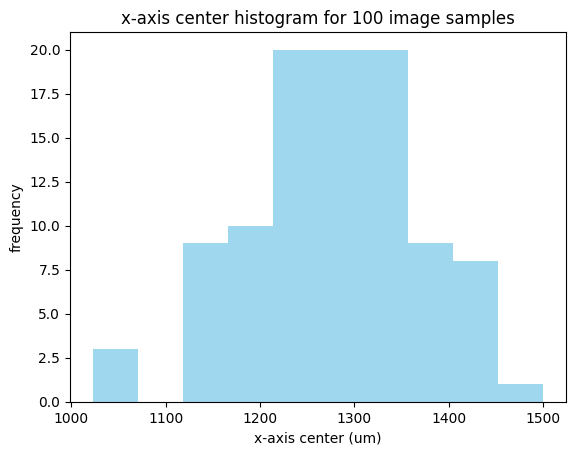

In [130]:

# #print(len(center_x_list))
# #print(center_x_list)
# print(np.std(center_x_list))
# plt.hist(center_x_list, bins=10,color='skyblue',alpha=0.8)
# plt.title('x-axis center histogram for 100 image samples')
# plt.xlabel('x-axis center (px)')
# plt.ylabel('frequency')
print("centroid error std:",np.std(center_x_list),"um")
plt.hist(center_x_list, bins=10,color='skyblue',alpha=0.8)
plt.title('x-axis center histogram for 100 image samples')
plt.xlabel('x-axis center (um)')
plt.ylabel('frequency')

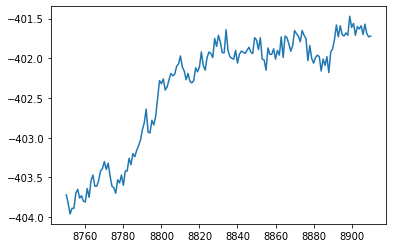

In [ ]:
plt.plot(input_energies[:-40], pd_val_nA[:-40])

In [ ]:
# 5/17/24
# new bar with AgB, CuAc, Cr(III) oxide


In [ ]:
energy_eV = lambda mono_deg_input: (mono_deg_input - mono_offset_deg)
energy_eV(28.93957213521199)

In [ ]:
mono_deg(6750)

29.821699155862255

In [ ]:
epics.caget('bl531_xps2:beamstop_x_mm')

11.8

In [ ]:
epics.caput('bl531_xps2:beamstop_x_mm', 12.5)

1

In [ ]:
epics.caput('bl531_xps1:mono_angle_deg', mono_deg(7000))


1

In [ ]:
epics.caget('bl531_xps1:mono_angle_deg')


28.93957213521199

In [ ]:

np.savetxt(f'/home/bl531/bl531_commissioning/20240424ML_commissioning/{file_name}.txt', np.vstack((input_energies, mono_angles_deg, pd_val_nA)).T)


In [ ]:
# lets look at the nexafs scans

mrl_save_path = '/home/bl531/bl531_commissioning/20240507ML_commissioning/'

spectra_files = sorted(f for f in os.listdir(mrl_save_path) if '_CuKedge' in f)

fig, ax = plt.subplots(figsize=(6,5))

for spec in spectra_files:
    spec_data = np.loadtxt(os.path.join(mrl_save_path, spec))

    energy = spec_data[:,0]
    mono_angle = spec_data[:,1]
    photodiode = spec_data[:,2]


    ax.plot(energy, photodiode, label=spec)
    #ax.set_xlim([8800, 8880])
   # ax.legend()

In [ ]:
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------
# saxs


In [ ]:
# single image acquisition on saxs detector
aqtime_s = 0.1
epics.caput('13PIL1:cam1:AcquireTime', aqtime_s * 1.5)
epics.caput('13PIL1:cam1:AcquirePeriod', aqtime_s)
epics.caput('13PIL1:cam1:Acquire',1)
time_sleep(5)
last_filename_ascii = epics.caget('13PIL1:cam1:FullFileName_RBV')
last_filename = bytes(last_filename_ascii).decode()
print(last_filename)

In [ ]:
# display 2d image 

#filepath = '/mnt/pilatus/' + 'BinaryNP_231222_WAXS_4802.tif'
#filepath = '/home/bl531/bl531_commissioning/20240422ML_commissioning/scan08_saxs_tulasi-PET-SeNP2_4899.tif'
filepath = last_filename[:-1]
filepath = '/mnt/data531/saxs_AgB_8650eV_1sec_5035.tif'

# read the image
im_tiff = Image.open(filepath)
# make the image a numpy array so that we can process it
im_np = np.squeeze(np.array(im_tiff.getdata()).reshape(im_tiff.size[1], im_tiff.size[0], 1))

# dealing with dyanmic range
#im_np[np.where(im_np>100000.0)] =0

dx_m = 172e-6
Nx_px = 981
Ny_px = 1043
Dx_m = Nx_px*dx_m
Dy_m = Ny_px*dx_m

fig=plt.figure(figsize=(5, 5), dpi= 120, facecolor='w', edgecolor='k')
extent = (-Dx_m/2 * 1e3, +Dx_m/2 * 1e3, -Dy_m/2 * 1e3, +Dy_m/2 * 1e3)

#mask = im_np > np.max(im_np)
#im_np[mask]=0

plt.imshow(im_np, extent=extent, cmap = 'inferno', norm=LogNorm())
plt.xlabel('horizontal Position [mm]')
plt.ylabel('vertical Positon [mm]')
plt.show()

np.percentile(im_np,99.999)   # this value should be below 1 million


In [ ]:
# lets look at the nexafs scans

mrl_save_path = '/home/bl531/bl531_commissioning/20240424ML_commissioning/'

spectra_files = sorted(f for f in os.listdir(mrl_save_path) if '_nexafs' in f)

fig, ax = plt.subplots(figsize=(6,5))

for spec in spectra_files:
    spec_data = np.loadtxt(os.path.join(mrl_save_path, spec))

    energy = spec_data[:,0]
    mono_angle = spec_data[:,1]
    photodiode = spec_data[:,2]


    ax.plot(energy, photodiode, label=spec)
   # ax.legend()

In [ ]:
# pilatus single image acquisition
aqtime_s = 4
epics.caput('13PIL1:cam1:AcquireTime', aqtime_s * 1.5)
epics.caput('13PIL1:cam1:AcquirePeriod', aqtime_s)
epics.caput('13PIL1:cam1:Acquire',1)
time_sleep(5)
last_filename_ascii = epics.caget('13PIL1:cam1:FullFileName_RBV')
last_filename = bytes(last_filename_ascii).decode()
print(last_filename)

In [ ]:
# display 2d image 


filepath = last_filename[:-1]
#filepath = '/mnt/data531/scan05_saxs_FeOH3_2sec_5141.tif'
filepath = '/mnt/data531/scan05_saxs_FeOH3_2sec_5141.tif'


# read the image
im_tiff = Image.open(filepath)
# make the image a numpy array so that we can process it
im_np = np.squeeze(np.array(im_tiff.getdata()).reshape(im_tiff.size[1], im_tiff.size[0], 1))

# dealing with dyanmic range
#im_np[np.where(im_np>100000.0)] =0

dx_m = 172e-6
Nx_px = 981
Ny_px = 1043
Dx_m = Nx_px*dx_m
Dy_m = Ny_px*dx_m

fig=plt.figure(figsize=(5, 5), dpi= 120, facecolor='w', edgecolor='k')
extent = (-Dx_m/2 * 1e3, +Dx_m/2 * 1e3, -Dy_m/2 * 1e3, +Dy_m/2 * 1e3)

#mask = im_np > np.max(im_np)
#im_np[mask]=0

plt.imshow(im_np, extent=extent, cmap = 'inferno', norm=LogNorm())
plt.xlabel('horizontal Position [mm]')
plt.ylabel('vertical Positon [mm]')
plt.show()

In [ ]:
# radial integration of a single pilatus image

#filepath = '/home/bl531/bl531_commissioning/20240422ML_commissioning/scan07_saxs_tulasi-PET-ctrl_10000eV/scan07_saxs_tulasi-PET-ctrl_4891.tif'
#filepath = '/home/bl531/bl531_commissioning/20240422ML_commissioning/scan08_saxs_tulasi-PET-SeNP2_dark_4898.tif'
#filepath = '/home/bl531/bl531_commissioning/20240422ML_commissioning/scan08_saxs_tulasi-PET-SeNP2_4899.tif'

az_range=[-180,180]
fig, ax = plt.subplots(figsize=(10,6))
#qvector_list = []
#radint_list = []
#energy_list = []
#for idx, image in tqdm(enumerate(images[:])):

#mono_angle = float(image[ image.find('deg') - 4: image.find('deg')])
#energy = calculate_output_energy(mono_angle)

# calibration performed in pyfai-calib2 by mrl on 4/22/24
dist = 1.47
poni1 = 0.10065476219862225
poni2 = 0.07695294434659085
rot1 = 0
rot2 = 0
rot3 = 0

energy = 7550

wavelength = ( (4.1357 * (10**-15)) * (2.9979 * (10**8))) / energy
calibrant = pyFAI.calibrant.get_calibrant("AgBh")
calibrant.wavelength = wavelength
detector = pyFAI.detectors.Pilatus1M(pixel1=0.000172, pixel2=0.000172, max_shape=(1043, 981))
ai = AzimuthalIntegrator(dist=dist, detector=detector, wavelength=wavelength, poni1=poni1, poni2=poni2, rot1=rot1, rot2=rot2, rot3=rot3)
#ai.maskfile = os.path.join(master_path, 'waxs_mask_mrl_april2024.edf')

im_path = os.path.join(filepath)
im_data = fabio.open(im_path)
im_array = im_data.data
im_array[im_array < 1] = 1
im_reduced = ai.integrate1d(im_array, npt=2000, azimuth_range=az_range)
qvector = im_reduced[0] / 10
intensity = im_reduced[1] # / diode_value

#log_intensity = np.log10(intensity)
#log_intensity_offset = log_intensity - 1 * idx
#intensity_offset = 10**(log_intensity_offset)
#intensity = intensity_offset

#qvector_list.append(qvector)
#radint_list.append(intensity)
#energy_list.append(energy)
energy_rounded = round(energy, 0)
ax.plot(qvector, intensity, label=f'{energy_rounded} eV')
ax.set_xscale('log')
ax.set_yscale('log')    
#ax.set_title(f'Fe(OH)3 Sample\nRadially integrated WAXS profile\nEnergy={energy} eV')
ax.set_xlabel(r'Scattering vector, $q \ (\mathrm{\AA^{-1}})$')
ax.set_ylabel('Scattering intensity (arbitrary units)')
ax.grid(which='major', color='lightgrey', linewidth=0.6); ax.grid(which='minor', color='lightgrey', linewidth=0.3)
ax.legend()
plt.show()

#if flag_save:
#    path_saxs_plot = os.path.join(save_path, f'{sample_folder}_saxs_{energy}eV.tif')
#    path_saxs_txt = os.path.join(save_path, f'{sample_folder}_saxs_{energy}eV.txt')
#    fig.savefig(path_saxs_plot, bbox_inches='tight', dpi=300)
#    np.savetxt(path_saxs_txt, np.vstack((qvector, intensity)).T)



In [ ]:
# saxs energy scan

Es_eV = np.linspace(6950, 7150, 101)        # same energy range/resolution as nexafs



epics.caput('bl531_xps1:mono_angle_deg',mono_deg(Es_eV[0]))
time_sleep(5)
filenames = ()
for i_e in tqdm(range(len(Es_eV))):
    mono_angle_deg = mono_deg(Es_eV[i_e])
    
    epics.caput('bl531_xps1:mono_angle_deg',mono_angle_deg)
    time_sleep(2)


    aqtime_s = 2
    epics.caput('13PIL1:cam1:AcquireTime', aqtime_s * 1.5)
    epics.caput('13PIL1:cam1:AcquirePeriod', aqtime_s)
    epics.caput('13PIL1:cam1:Acquire',1)
    time_sleep(5)

    last_filename_ascii = epics.caget('13PIL1:cam1:FullFileName_RBV')
    last_filename = bytes(last_filename_ascii).decode()
    filenames += (last_filename,)



In [ ]:
np.percentile(im_np, 99.99)

In [ ]:
epics.caget('bl531_xps1:mono_angle_deg')

In [ ]:
mono_deg(7150)

In [ ]:
img = ()
for i_e in range(len(Es_eV)):
    filepath = filenames[i_e][:-1]
    # read the image
    im_tiff = Image.open(filepath)
    # make the image a numpy array so that we can process it
    im_np = np.squeeze(np.array(im_tiff.getdata()).reshape(im_tiff.size[1], im_tiff.size[0], 1))
    img += (im_np,)


In [ ]:
# tracking flux on top of detector to see if we can see fluorescence nexafs

fig, ax = plt.subplots()

flux = Es_eV*0
for i_e in range(len(Es_eV)):
    flux[i_e] = np.sum(img[i_e][0:200, 0:200])

ax.plot(Es_eV, flux)
#ax.set_xlim([0,100])
#ax.set_ylim([2.4e6, 2.8e6])


In [ ]:
# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# below is the code from april 22, 2024

In [ ]:
# execute nexafs scan (to collect on photodiode) across an inputted energy range

input_energies = np.linspace(8965, 8995, 101)
mono_angles_deg = mono_deg(input_energies)
pd_val_nA = mono_angles_deg*0

epics.caput('bl531_xps1:mono_angle_deg', mono_angles_deg[0])
time_sleep(5)
for i_a in np.arange(len(mono_angles_deg)):
    epics.caput('bl531_xps1:mono_angle_deg', mono_angles_deg[i_a])
    time_sleep(0.5)
    pd_val_nA[i_a] = epics.caget('bl201-beamstop:current')

In [ ]:
# make a quick plot of the photodiode signal

plt.plot(input_energies,pd_val_nA)
plt.xlabel('Beamline Energy (eV)')
plt.ylabel('Beamstop Diode Intensity [nA]')
plt.show()

# save data since photodiode signals are not archived (i think)!
file_name = 'scan01_nexafs_CopperFoil_photodiode'
#file_name = 'scan02_nexafs_CopperFoil_photodiode_dark'
#file_name = 'scan03_nexafs_CopperFoil_photodiode_dark2'

#np.savetxt(f'/home/bl531/bl531_commissioning/20240422ML_commissioning/{file_name}.txt', np.vstack((input_energies, mono_angles_deg, pd_val_nA)).T)

In [ ]:
# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# now i've pulled vacuum on a direct beam sample
# and i ran tulasis two PET-SeNP samples using these cells

In [ ]:
# lets do a wide energy scan on the photodiode to see what the bkg on is for a direct beam   

input_energies = np.linspace(5000, 11000, 201)
mono_angles_deg = mono_deg(input_energies)
pd_val_nA = mono_angles_deg*0

epics.caput('bl531_xps1:mono_angle_deg', mono_angles_deg[0])
time_sleep(5)
for i_a in np.arange(len(mono_angles_deg)):
    epics.caput('bl531_xps1:mono_angle_deg', mono_angles_deg[i_a])
    time_sleep(0.5)
    pd_val_nA[i_a] = epics.caget('bl201-beamstop:current')


# make a quick plot of the photodiode signal
plt.plot(input_energies,pd_val_nA)
plt.xlabel('Beamline Energy (eV)')
plt.ylabel('Beamstop Diode Intensity [nA]')
plt.show()

# save data since photodiode signals are not archived (i think)!
file_name = 'scan04_nexafs_directbeam_photodiode_dark'
file_name = 'scan05_nexafs_directbeam_photodiode'

#np.savetxt(f'/home/bl531/bl531_commissioning/20240422ML_commissioning/{file_name}.txt', np.vstack((input_energies, mono_angles_deg, pd_val_nA)).T)

In [ ]:
# pilatus time :)  single image acquisition
aqtime_s = 1
epics.caput('13PIL1:cam1:AcquireTime', aqtime_s * 1.5)
epics.caput('13PIL1:cam1:AcquirePeriod', aqtime_s)
epics.caput('13PIL1:cam1:Acquire',1)
time_sleep(5)
last_filename_ascii = epics.caget('13PIL1:cam1:FullFileName_RBV')
last_filename = bytes(last_filename_ascii).decode()
print(last_filename)

In [ ]:
# display 2d image 

#filepath = '/mnt/pilatus/' + 'BinaryNP_231222_WAXS_4802.tif'
#filepath = '/mnt/pilatus/' + 'FeNOM_20231221_3756.tif'
#filepath = 'afp://bl531user@bl531data.local/User_Data/' + last_filename[13:-1]
filepath = f'/home/bl531/bl531_commissioning/20240422ML_commissioning/{last_filename[13:-1]}'
#filepath = '/home/bl531/bl531_commissioning/20240422ML_commissioning/scan06_saxs_directbeam_5000-11000eV/scan06_saxs_directbeam_4882.tif'
filepath = '/home/bl531/bl531_commissioning/20240422ML_commissioning/scan07_saxs_tulasi-PET-ctrl_4894.tif'
filepath = '/home/bl531/bl531_commissioning/20240422ML_commissioning/scan08_saxs_tulasi-PET-SeNP2_4899.tif'


# read the image
im_tiff = Image.open(filepath)
# make the image a numpy array so that we can process it
im_np = np.squeeze(np.array(im_tiff.getdata()).reshape(im_tiff.size[1], im_tiff.size[0], 1))

# dealing with dyanmic range
#im_np[np.where(im_np>100000.0)] =0

dx_m = 172e-6
Nx_px = 981
Ny_px = 1043
Dx_m = Nx_px*dx_m
Dy_m = Ny_px*dx_m

fig=plt.figure(figsize=(5, 5), dpi= 120, facecolor='w', edgecolor='k')
extent = (-Dx_m/2 * 1e3, +Dx_m/2 * 1e3, -Dy_m/2 * 1e3, +Dy_m/2 * 1e3)

#mask = im_np > np.max(im_np)
#im_np[mask]=0

plt.imshow(im_np, extent=extent, cmap = 'inferno', norm=LogNorm())
plt.xlabel('horizontal Position [mm]')
plt.ylabel('vertical Positon [mm]')
plt.show()

In [ ]:
# check that you are not oversaturating detector... if so, adjust exposure time 

np.percentile(im_np,99.9)   # this value should be below 1 million

In [ ]:
# pilatus energy scan

Es_eV = np.linspace(5000, 11000, 61)

epics.caput('bl531_xps1:mono_angle_deg',mono_deg(Es_eV[0]))
time_sleep(5)
filenames = ()
for i_e in range(len(Es_eV)):
    mono_angle_deg = mono_deg(Es_eV[i_e])
    
    epics.caput('bl531_xps1:mono_angle_deg',mono_angle_deg)
    time_sleep(2)

    aqtime_s = 1
    epics.caput('13PIL1:cam1:AcquireTime', aqtime_s * 1.5)
    epics.caput('13PIL1:cam1:AcquirePeriod', aqtime_s)
    epics.caput('13PIL1:cam1:Acquire',1)
    time_sleep(5)

    last_filename_ascii = epics.caget('13PIL1:cam1:FullFileName_RBV')
    last_filename = bytes(last_filename_ascii).decode()[13:-1]
    filenames += (last_filename,)


In [ ]:
# radial integration of a single pilatus image

filepath = '/home/bl531/bl531_commissioning/20240422ML_commissioning/scan07_saxs_tulasi-PET-ctrl_10000eV/scan07_saxs_tulasi-PET-ctrl_4891.tif'
filepath = '/home/bl531/bl531_commissioning/20240422ML_commissioning/scan08_saxs_tulasi-PET-SeNP2_dark_4898.tif'
filepath = '/home/bl531/bl531_commissioning/20240422ML_commissioning/scan08_saxs_tulasi-PET-SeNP2_4899.tif'

az_range=[-180,180]
fig, ax = plt.subplots(figsize=(10,6))
#qvector_list = []
#radint_list = []
#energy_list = []
#for idx, image in tqdm(enumerate(images[:])):
mono_angle = 24.19
energy = 10000
#mono_angle = float(image[ image.find('deg') - 4: image.find('deg')])
#energy = calculate_output_energy(mono_angle)

# calibration performed in pyfai-calib2 by mrl on 4/22/24
dist = 1.47
poni1 = 0.10065476219862225
poni2 = 0.07695294434659085
rot1 = 0
rot2 = 0
rot3 = 0

wavelength = ( (4.1357 * (10**-15)) * (2.9979 * (10**8))) / energy
calibrant = pyFAI.calibrant.get_calibrant("AgBh")
calibrant.wavelength = wavelength
detector = pyFAI.detectors.Pilatus1M(pixel1=0.000172, pixel2=0.000172, max_shape=(1043, 981))
ai = AzimuthalIntegrator(dist=dist, detector=detector, wavelength=wavelength, poni1=poni1, poni2=poni2, rot1=rot1, rot2=rot2, rot3=rot3)
#ai.maskfile = os.path.join(master_path, 'waxs_mask_mrl_april2024.edf')

im_path = os.path.join(filepath)
im_data = fabio.open(im_path)
im_array = im_data.data
im_array[im_array < 1] = 1
im_reduced = ai.integrate1d(im_array, npt=2000, azimuth_range=az_range)
qvector = im_reduced[0] / 10
intensity = im_reduced[1] # / diode_value

#log_intensity = np.log10(intensity)
#log_intensity_offset = log_intensity - 1 * idx
#intensity_offset = 10**(log_intensity_offset)
#intensity = intensity_offset

#qvector_list.append(qvector)
#radint_list.append(intensity)
#energy_list.append(energy)
energy_rounded = round(energy, 0)
ax.plot(qvector, intensity, label=f'{energy_rounded} eV')
ax.set_xscale('log')
ax.set_yscale('log')    
#ax.set_title(f'Fe(OH)3 Sample\nRadially integrated WAXS profile\nEnergy={energy} eV')
ax.set_xlabel(r'Scattering vector, $q \ (\mathrm{\AA^{-1}})$')
ax.set_ylabel('Scattering intensity (arbitrary units)')
ax.grid(which='major', color='lightgrey', linewidth=0.6); ax.grid(which='minor', color='lightgrey', linewidth=0.3)
ax.legend()
plt.show()

#if flag_save:
#    path_saxs_plot = os.path.join(save_path, f'{sample_folder}_saxs_{energy}eV.tif')
#    path_saxs_txt = os.path.join(save_path, f'{sample_folder}_saxs_{energy}eV.txt')
#    fig.savefig(path_saxs_plot, bbox_inches='tight', dpi=300)
#    np.savetxt(path_saxs_txt, np.vstack((qvector, intensity)).T)



In [ ]:
# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# now i have the Copper Foil back in the chamber and i pulled vacuum
# want to try some spectroscopy (NEXAFS, EXAFS) at Cu K-edge

In [ ]:
# lets look at the Cu K-edge

input_energies = np.linspace(8965, 8995, 101)
mono_angles_deg = mono_deg(input_energies)
pd_val_nA = mono_angles_deg*0

epics.caput('bl531_xps1:mono_angle_deg', mono_angles_deg[0])
time_sleep(5)
for i_a in np.arange(len(mono_angles_deg)):
    epics.caput('bl531_xps1:mono_angle_deg', mono_angles_deg[i_a])
    time_sleep(5)
    pd_val_nA[i_a] = epics.caget('bl201-beamstop:current')


# make a quick plot of the photodiode signal
plt.plot(input_energies,pd_val_nA)
plt.xlabel('Beamline Energy (eV)')
plt.ylabel('Beamstop Diode Intensity [nA]')
plt.show()

# save data since photodiode signals are not archived (i think)!
file_name = 'scan12_nexafs_CuFoil-vacuum_photodiode_5sec'



np.savetxt(f'/home/bl531/bl531_commissioning/20240422ML_commissioning/{file_name}.txt', np.vstack((input_energies, mono_angles_deg, pd_val_nA)).T)

In [ ]:
# 0.5 sec photodiode scan for reference (to compare to 5 sec scan above)

plt.plot(input_energies,pd_val_nA)
plt.xlabel('Beamline Energy (eV)')
plt.ylabel('Beamstop Diode Intensity [nA]')

plt.show()

In [ ]:
# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# antoines code from 20240422ML_calibration.ipynb

In [ ]:
# testing EPICS with the monochromator
epics.caget('bl531_xps1:mono_angle_deg')

In [ ]:

epics.caget('bl201-beamstop:current')

In [ ]:
import matplotlib.pyplot as plt
from time import sleep as time_sleep

mono_angles_deg = np.linspace(25,26,101)
pd_val_nA = mono_angles_deg*0


epics.caput('bl531_xps1:mono_angle_deg', mono_angles_deg[0])
time_sleep(5)
for i_a in np.arange(len(mono_angles_deg)):
    epics.caput('bl531_xps1:mono_angle_deg', mono_angles_deg[i_a])
    time_sleep(0.5)
    pd_val_nA[i_a] = epics.caget('bl201-beamstop:current')




In [ ]:
plt.plot(mono_angles_deg,pd_val_nA)
plt.xlabel('Mono angle [deg]')
plt.ylabel('beamstop diode intensity [nA]')
plt.show()


In [ ]:
pd_val_nA

2.3411957430688592


Text(0, 0.5, 'frequency')

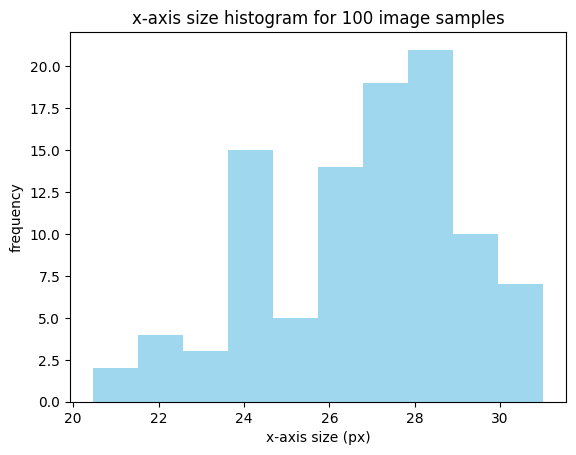

In [31]:
print(np.std(size_x_list))
plt.hist(size_x_list, bins=10,color='skyblue',alpha=0.8)
plt.title('x-axis size histogram for 100 image samples')
plt.xlabel('x-axis size (px)')
plt.ylabel('frequency')

0.39180980508812135


Text(0, 0.5, 'frequency')

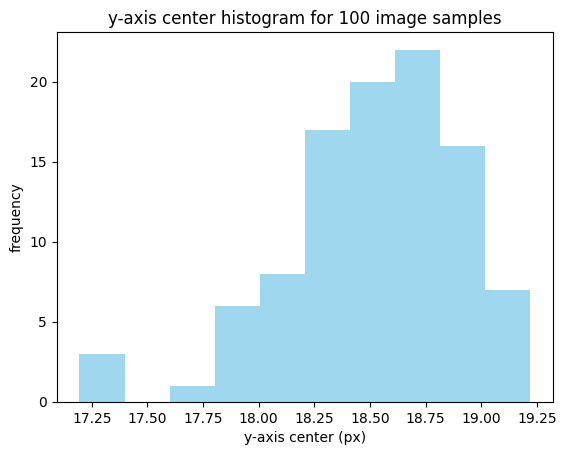

In [32]:
print(np.std(center_y_list))
plt.hist(center_y_list, bins=10,color='skyblue',alpha=0.8)
plt.title('y-axis center histogram for 100 image samples')
plt.xlabel('y-axis center (px)')
plt.ylabel('frequency')

Text(0, 0.5, 'frequency')

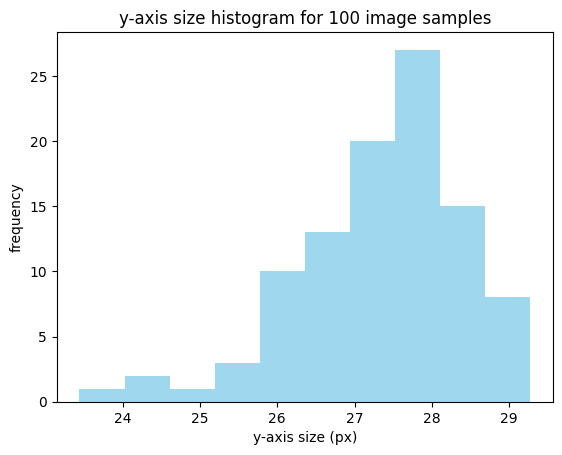

In [33]:
plt.hist(size_y_list, bins=10,color='skyblue',alpha=0.8)
plt.title('y-axis size histogram for 100 image samples')
plt.xlabel('y-axis size (px)')
plt.ylabel('frequency')